In [1]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd

sys.path.append(str(
    Path.cwd().parent / 'scripts'
))

from solve_network import insert_battery_commitments

In [2]:
regions = gpd.read_file(
    Path.cwd().parent / 'data' / 'preprocessed' / 'zonal_layout.geojson'
).set_index('name')

source = ['Southern England', 'Southern Belt']
regions.loc['South', 'geometry'] = regions.loc[source].union_all()
regions.drop(source, inplace=True)

In [3]:
large_start = '2024-03-01'
small_start = '2024-03-19'
end = '2024-03-26'

In [4]:
real_bids = []

# for day in pd.date_range(start=large_start, end=end):
for day in pd.date_range(start=small_start, end=end):
    bids = pd.read_csv(
        Path.cwd().parent / 'data' / 'base' / day.strftime('%Y-%m-%d') / 'bids.csv',
        index_col=[0,1]
    )
    real_bids.append(bids)

idx = pd.IndexSlice

real_bids = pd.concat(real_bids).loc[idx[:, 'vol'], :]
real_bids.index = pd.to_datetime(real_bids.index.get_level_values(0))

In [5]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_static_s_nodal.nc'
)

INFO:pypsa.io:Imported network network_static_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [6]:
buses = gpd.GeoDataFrame(
    n.buses[['x', 'y']],
    geometry=gpd.points_from_xy(n.buses.x, n.buses.y),
    crs='EPSG:4326'
)

In [7]:
bmus = pd.read_csv(
    Path.cwd().parent /
    'data' /
    'preprocessed' /
    'prepared_bmus.csv',
    index_col=0
    )

In [10]:
buses = pypsa.Network(Path.cwd().parent / 'results' / '2024-03-22' / 'network_static.nc').buses
# buses = pypsa.Network(Path.cwd().parent / 'results' / '2024-03-22' / 'network_static_s_nodal.nc').buses

INFO:pypsa.io:Imported network network_static.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [11]:
ss = bmus.loc[
    (bmus['lat'] != 'distributed') &
    (bmus['lat'] != 0)
]
bm_gpd = gpd.GeoDataFrame(ss[[]], geometry=gpd.points_from_xy(
    buses.loc[ss.bus, 'x'].values,
    buses.loc[ss.bus, 'y'].values,
    ),
    crs='EPSG:4326')
bm_gpd = bm_gpd.sjoin(regions, how='left')

In [12]:
bm_gpd = gpd.GeoDataFrame(ss[[]], geometry=gpd.points_from_xy(
    buses.loc[ss.bus, 'x'].values,
    buses.loc[ss.bus, 'y'].values,
    ),
    crs='EPSG:4326')

bm_gpd = bm_gpd.sjoin(regions, how='left')
grouped_bids = real_bids.replace(np.nan, 0).T

missing = grouped_bids.index.difference(bmus.index)
grouped_bids.drop(missing, inplace=True)

grouped_bids = (
    grouped_bids
    .groupby(grouped_bids.index.map(lambda x: bm_gpd.loc[x, 'name']))
    .sum()
    .T
)
grouped_bids = grouped_bids[regions.index]

In [13]:
flow_constraints = {
    day.strftime('%Y-%m-%d'): pd.read_csv(
        Path.cwd().parent /
        'data' /
        'base' /
        day.strftime('%Y-%m-%d') /
        'boundary_flow_constraints.csv',
        index_col=0
    )
    for day in pd.date_range(start=small_start, end=end)
}

<Axes: >

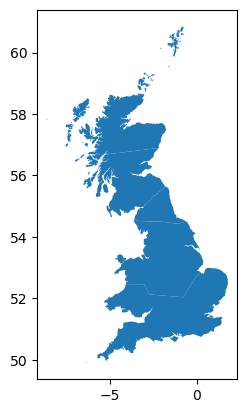

In [14]:
regions.plot()

In [15]:
calibrated_boundaries = [
    'SSE-SP', 'SCOTEX', 'SSHARN', 'FLOWSTH'
]

In [175]:
def insert_flow_constraints(
    n,
    flow_constraints,
    boundaries,
    calibration_parameters,
    ):

    assert isinstance(calibration_parameters, dict)

    for boundary in flow_constraints.columns:

        limit = flow_constraints[boundary]
        lines = pd.Index(boundaries[boundary], dtype=str)

        try:
            nameplate_capacity = n.lines.loc[lines, 's_nom'].sum()
        except KeyError:
            nameplate_capacity = n.links.loc[lines, 'p_nom'].sum()
        
        flow_max_pu = limit / nameplate_capacity * calibration_parameters[boundary]

        if lines[0] in n.lines.index:
            for line in lines:
                n.lines_t.s_max_pu[line] = flow_max_pu.values
                n.lines_t.s_min_pu[line] = - flow_max_pu.values
        else:
            for line in lines:
                n.links_t.p_max_pu[line] = flow_max_pu.values
                n.links_t.p_min_pu[line] = - flow_max_pu.values
    
    # print('warning: testing experimental reduction of line capacity efficiency')
    # if n.lines.empty:
    #     n.links.loc[n.links.carrier == 'AC', 'efficiency'] = 0.995

In [176]:
def get_regional_bidding_volume(nat, bal, regions):
    """
    Returns the bidding volume of the network.

    Parameters:
        nat(pypsa.Network): The national wholesale market optimum.
        bal(pypsa.Network): The wholesale market after redispatch.
        regions(gpd.GeoDataFrame): Regions by which bids are aggregated.
    """

    bidding_volume = pd.DataFrame(index=nat.snapshots, columns=regions.index)
    buses = gpd.GeoDataFrame(
        bal.buses, geometry=gpd.points_from_xy(bal.buses.x, bal.buses.y)
    )

    for region, geometry in regions.geometry.items():

        region_bvol = pd.Series(0, nat.snapshots)
        region_buses = buses.loc[buses.geometry.within(geometry)].index

        wind = bal.generators.index[
            (bal.generators.carrier.str.contains('wind')) &
            (bal.generators.bus.isin(region_buses))
            ]
        solar = bal.generators.index[
            (bal.generators.carrier.str.contains('solar')) &
            (bal.generators.bus.isin(region_buses))
            ]
        dispatchable = bal.generators.index[
            (bal.generators.carrier.isin(['fossil', 'biomass', 'coal'])) &
            (bal.generators.bus.isin(region_buses))
            ]
        water = bal.storage_units.index[
            (bal.storage_units.carrier.isin(['cascade', 'hydro'])) &
            (bal.storage_units.bus.isin(region_buses))
            ]

        for plants in [wind, solar, dispatchable, dispatchable]:
            
            region_bvol += (
                nat.generators_t.p[plants].sum(axis=1) -
                bal.generators_t.p[plants].sum(axis=1)
            ).clip(lower=0)
        
        region_bvol += (
            nat.storage_units_t.p[water].sum(axis=1) -
            bal.storage_units_t.p[water].sum(axis=1)
        ).clip(lower=0)
    
        bidding_volume[region] = region_bvol

    return bidding_volume * 0.5


In [177]:
def get_model_bidding_volume(day, regions, boundaries, calibration_factors):

    if isinstance(day, pd.Timestamp):
        day = day.strftime('%Y-%m-%d')

    n_nat = pypsa.Network(
        Path.cwd().parent / 'results' / day / 'network_static_s_national.nc'
    )
    n_nat_red = pypsa.Network(
        Path.cwd().parent / 'results' / day / 'network_static_s_nodal.nc'
    )

    assert n_nat_red.lines.empty

    insert_flow_constraints(
        n_nat_red,
        flow_constraints[day],
        boundaries,
        calibration_factors
        )

    n_nat.optimize()
    insert_battery_commitments(n_nat, n_nat_red)

    n_nat_red.optimize()

    return get_regional_bidding_volume(n_nat, n_nat_red, regions)


'''
model_bidding_volume = get_model_bidding_volume(
    '2024-03-22',
    regions
    )
'''

"\nmodel_bidding_volume = get_model_bidding_volume(\n    '2024-03-22',\n    regions\n    )\n"

In [178]:
def get_real_bidding_volume(grouped_bids, index):

    gb = grouped_bids.copy()
    # gb.index = pd.to_datetime(gb.index)
    # print(gb)
    gb = grouped_bids.loc[index.tz_localize(gb.index.tz)]
    return gb
    # return gb.groupby(gb.index.hour).sum()

In [195]:
boundaries = {
    # 'SSE-SP': [13161, 6241, 6146, 6145, 6149, 6150],
    'SSE-SP': [13161, 6241, 6146, 6238],
    # 'SCOTEX': [14109, 6139, 11758],
    # 'SSHARN': [11778, 11780, 5225],
    'SCOTEX': [14109, 6139, 11758, 8009],
    'SSHARN': [11778, 11780, 5225, 8009],
    'SEIMP': [6121, 12746, 11742],
    'FLOWSTH': [5203, 11528, 11764, 6203, 5207]
}

In [196]:
import matplotlib.pyplot as plt

In [210]:
# %%capture
import logging
logging.disable(logging.CRITICAL)

results = {}

calibration_factors = {
    'SSE-SP': 1.,
    'SCOTEX': 0.6,
    'SSHARN': 0.6,
    'FLOWSTH': 0.6,
    'SEIMP': 1.,
}

dates = pd.date_range(start='2024-03-19', end=end)

# for factor in np.arange(0.55, 0.7, 0.05):
for run in range(1,2):

    # results[factor] = {}
    results[run] = calibration_factors.copy()

    model_vols = []
    real_vols = []

    for day in dates:

        day = day.strftime('%Y-%m-%d')

        m = get_model_bidding_volume(day, regions, boundaries, calibration_factors)
        r = get_real_bidding_volume(grouped_bids, m.index)

        model_vols.append(m)
        real_vols.append(r)


    results[run]['model'] = pd.concat(model_vols)
    results[run]['real'] = pd.concat(real_vols)


c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 63.36it/s]
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 41.13it/s]
c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previ

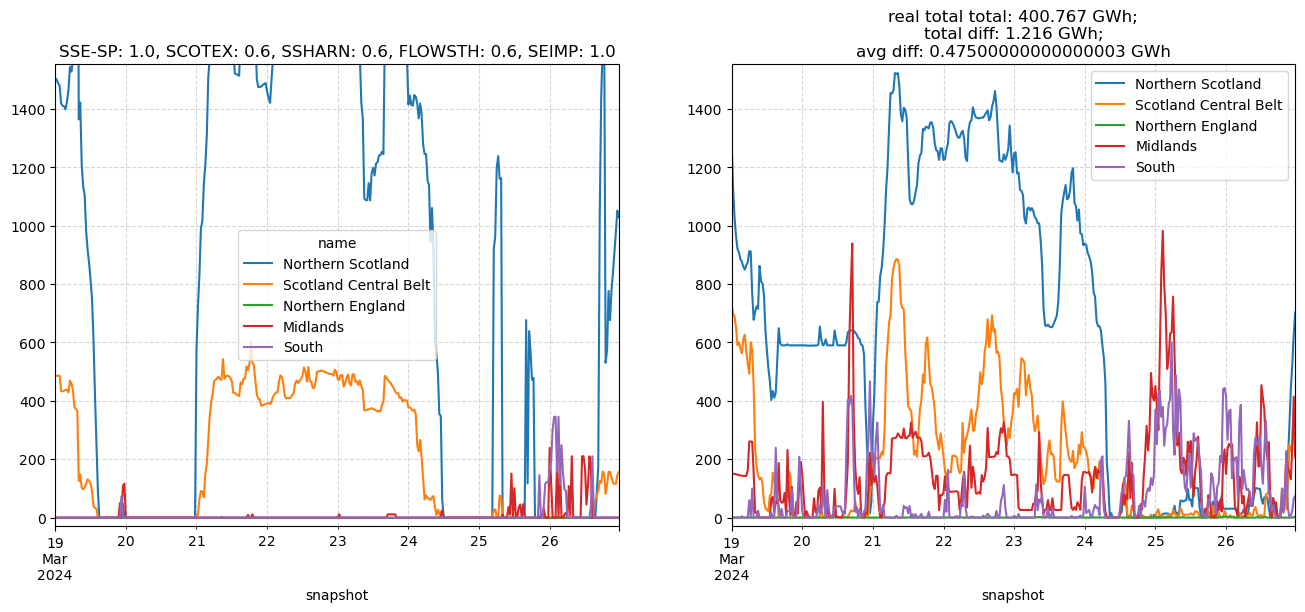

In [211]:
for factor, data in results.items():

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    results[factor]['model'].plot(ax=axs[0])
    results[factor]['real'].plot(ax=axs[1])

    axs[0].set_ylim(-30, results[factor]['real'].max().max() + 30)
    axs[1].set_ylim(-30, results[factor]['real'].max().max() + 30)

    title = ', '.join([f'{k}: {v}' for k, v in calibration_factors.items()])
    axs[0].set_title(title)

    for ax in axs:
        ax.grid(True, which='both', linestyle='--', alpha=0.5)

    model_total = results[run]['model'].sum(axis=1)
    model_total.index = pd.to_datetime(model_total.index).tz_localize('utc')
    real_total = results[run]['real'].sum(axis=1)

    total_diff = model_total.sum() - real_total.sum()
    avg_diff = (model_total - real_total).abs().mean()

    axs[1].set_title(f'real total total: {int(real_total.sum())*1e-3} GWh;\ntotal diff: {int(total_diff) * 1e-3} GWh;\navg diff: {int(avg_diff)*1e-3} GWh')

    plt.show()

In [119]:
nodal_regions = gpd.read_file(
    Path.cwd().parent / 'data' / 'regions_onshore_s.geojson'
).set_index('name')

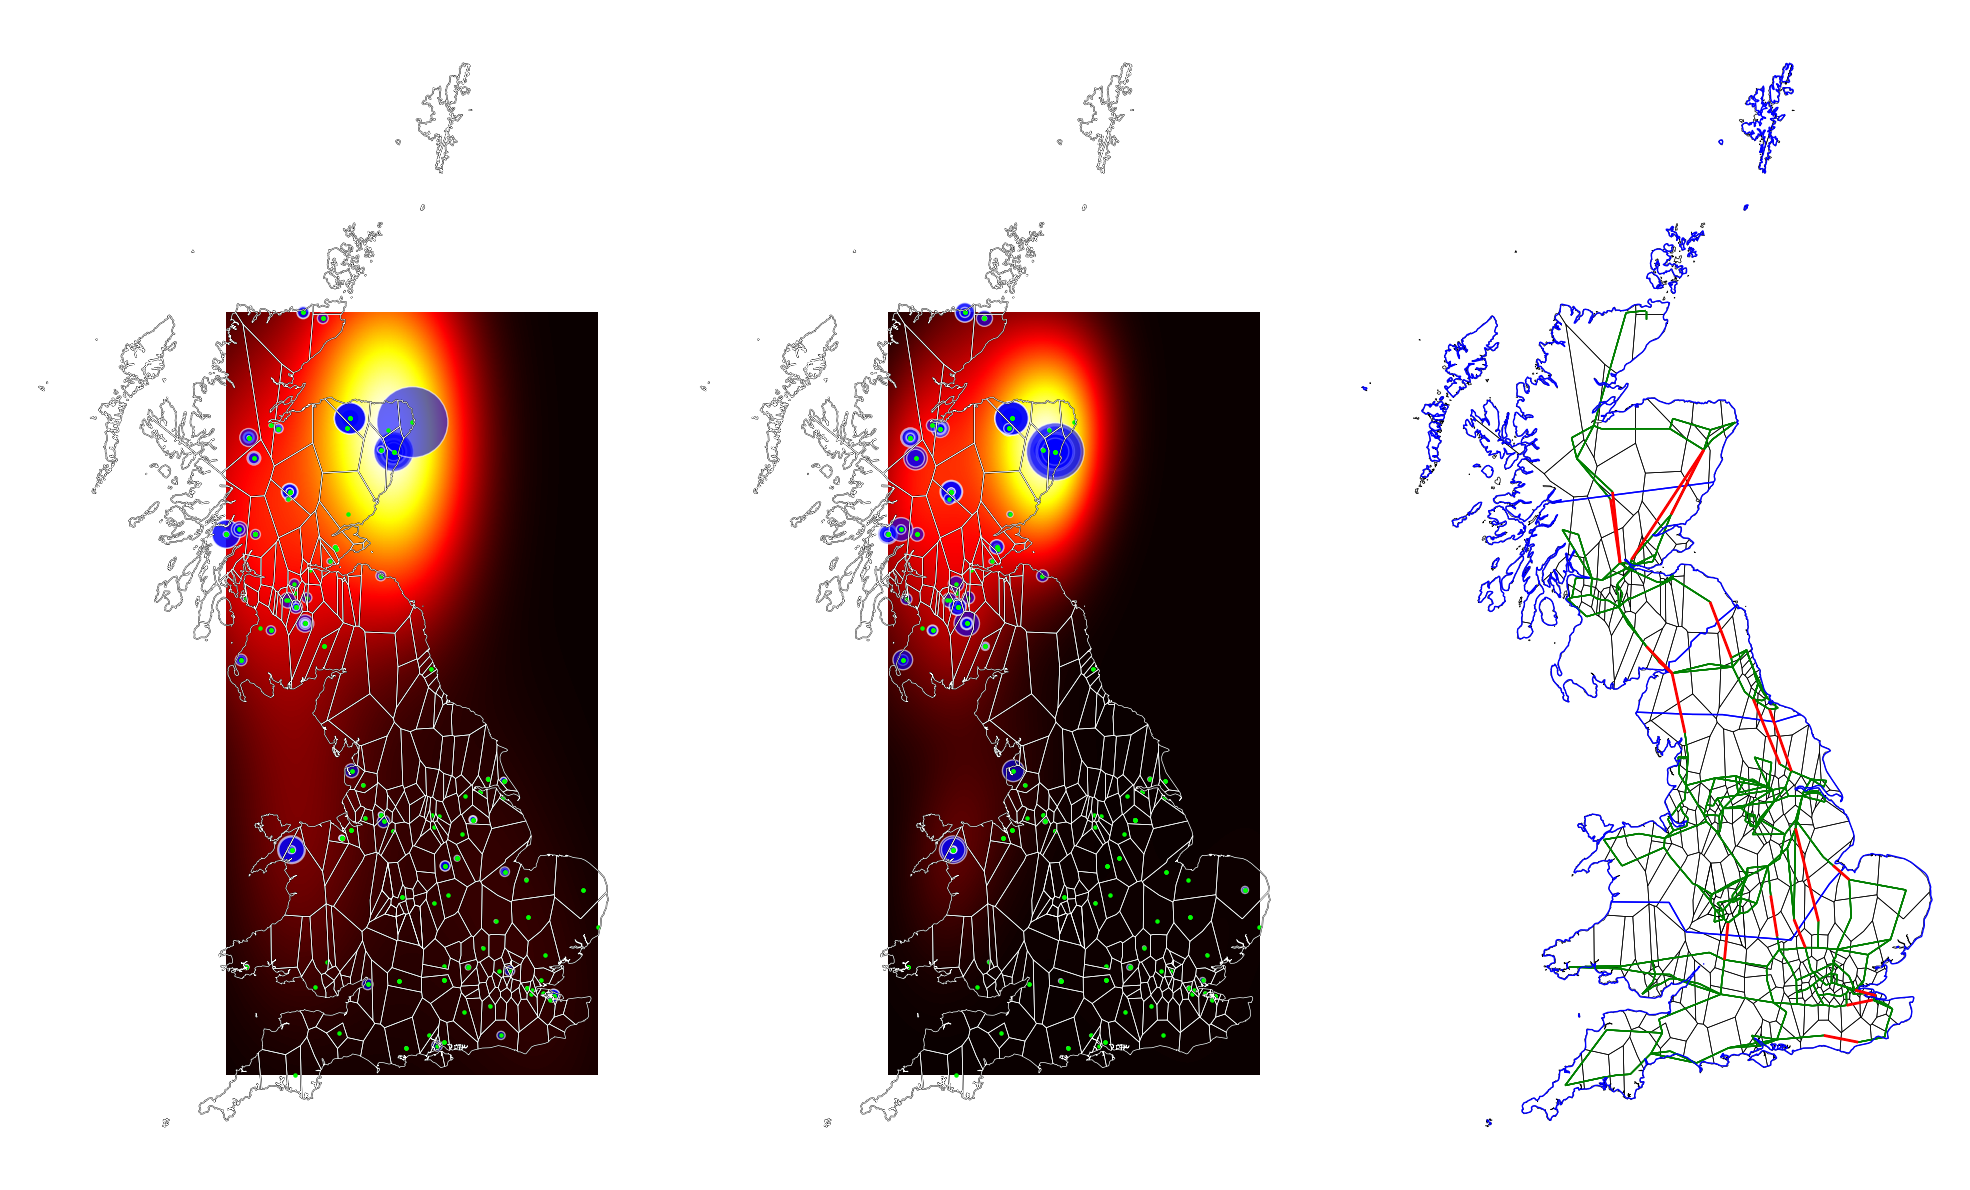

In [120]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import matplotlib.ticker as ticker


def bvol_to_ax(df, ax, regions):

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df.mul(1e-2),
        geometry=gpd.points_from_xy(
            # bmus.loc[df.index, 'lon'],
            # bmus.loc[df.index, 'lat']
            buses.loc[bmus.loc[df.index, 'bus'], 'x'],
            buses.loc[bmus.loc[df.index, 'bus'], 'y'],
            ),
        crs='EPSG:4326'
    )

    gdf_projected = gdf.to_crs('EPSG:3857')
    x = gdf_projected.geometry.x
    y = gdf_projected.geometry.y

    xmin, ymin, xmax, ymax = x.min(), y.min(), x.max(), y.max()

    grid_size = 500
    xx, yy = np.mgrid[xmin:xmax:grid_size*1j, ymin:ymax:grid_size*1j]
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])

    positions = np.vstack([x, y])
    kde = gaussian_kde(positions, weights=gdf.iloc[:,0].values)
    kde_values = np.reshape(kde(grid_coords).T, xx.shape)

    ax.imshow(
        np.rot90(kde_values),
        cmap='hot',
        extent=[xmin, xmax, ymin, ymax]
    )


    ax.scatter(x, y, c='blue', s=df.values/10, edgecolor='white', alpha=0.6)
    ax.scatter(x, y, c='lime', s=5, edgecolor='lime', alpha=1)


    # ax.set_title('2D KDE Heatmap of Spatial Distribution')

    transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    def x_formatter(x, pos):
        lon, lat = transformer.transform(x, ymin)
        return f"{lon:.2f}"

    def y_formatter(y, pos):
        lon, lat = transformer.transform(xmin, y)
        return f"{lat:.2f}"

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(x_formatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    (
        regions
        .to_crs('EPSG:3857')
        .plot(ax=ax, edgecolor='black', facecolor='none', linestyle='-')
    )

fig, axs = plt.subplots(1, 3, figsize=(20, 12))

df = real_bids.sum()

first = slice('2024-03-20', '2024-03-21')
# df = real_bids.loc[pd.Timestamp('2024-03-20', tz='utc'):pd.Timestamp('2024-03-21', tz='utc')].sum()
df = real_bids.loc[first].sum()

df = df.loc[df.index.intersection(bmus.index)]

# print(df)
# import sys
# sys.exit()

# bvol_to_ax(df, axs[0], regions)
bvol_to_ax(df, axs[0], nodal_regions)

second = slice('2024-03-22', '2024-03-23')
df = real_bids.loc[second].sum()
df = df.loc[df.index.intersection(bmus.index)]

# bvol_to_ax(df, axs[1], regions)
bvol_to_ax(df, axs[1], nodal_regions)

for ax in axs[:2]:
    (
        nodal_regions
        .to_crs('EPSG:3857')
        .plot(
            ax=ax,
            color='none',
            edgecolor='w',
            linewidth=0.5
            )
    )
    ax.axis('off')


axs[2].axis('off')
(
    nodal_regions
    .to_crs('EPSG:3857')
    .plot(
        ax=axs[2],
        color='none',
        edgecolor='k',
        linewidth=0.5
        )
)

from shapely.geometry import LineString

for boundary, lines in boundaries.items():

    line_geoms = list()    

    if n.lines.empty:
        all_lines = n.links.loc[n.links.carrier == 'AC'].index
    else:
        all_lines = n.lines.index


    for l in all_lines:

        try:
            line_geoms.append(
                LineString([
                    # (buses.loc[n.lines.loc[l, 'bus0'], 'x'], buses.loc[n.lines.loc[l, 'bus0'], 'y']),
                    # (buses.loc[n.lines.loc[l, 'bus1'], 'x'], buses.loc[n.lines.loc[l, 'bus1'], 'y'])
                    (buses.loc[n.lines.loc[str(l), 'bus0'], 'x'], buses.loc[n.lines.loc[str(l), 'bus0'], 'y']),
                    (buses.loc[n.lines.loc[str(l), 'bus1'], 'x'], buses.loc[n.lines.loc[str(l), 'bus1'], 'y'])
                ])
            )
        except KeyError:
            line_geoms.append(
                LineString([
                    (buses.loc[n.links.loc[str(l), 'bus0'], 'x'], buses.loc[n.links.loc[str(l), 'bus0'], 'y']),
                    (buses.loc[n.links.loc[str(l), 'bus1'], 'x'], buses.loc[n.links.loc[str(l), 'bus1'], 'y'])
                ])
            )
    
    line_gdf = gpd.GeoDataFrame(geometry=line_geoms, crs='EPSG:4326').to_crs('EPSG:3857')
    line_gdf.plot(ax=axs[2], color='green', linewidth=1, zorder=1)

    line_geoms = list()

    for l in lines:

        try:
            line_geoms.append(
                LineString([
                    # (buses.loc[n.lines.loc[l, 'bus0'], 'x'], buses.loc[n.lines.loc[l, 'bus0'], 'y']),
                    # (buses.loc[n.lines.loc[l, 'bus1'], 'x'], buses.loc[n.lines.loc[l, 'bus1'], 'y'])
                    (buses.loc[n.lines.loc[str(l), 'bus0'], 'x'], buses.loc[n.lines.loc[str(l), 'bus0'], 'y']),
                    (buses.loc[n.lines.loc[str(l), 'bus1'], 'x'], buses.loc[n.lines.loc[str(l), 'bus1'], 'y'])
                ])
            )
        except KeyError:
            line_geoms.append(
                LineString([
                    (buses.loc[n.links.loc[str(l), 'bus0'], 'x'], buses.loc[n.links.loc[str(l), 'bus0'], 'y']),
                    (buses.loc[n.links.loc[str(l), 'bus1'], 'x'], buses.loc[n.links.loc[str(l), 'bus1'], 'y'])
                ])
            )
    
    line_gdf = gpd.GeoDataFrame(geometry=line_geoms, crs='EPSG:4326').to_crs('EPSG:3857')
    line_gdf.plot(ax=axs[2], color='red', linewidth=2)

regions.to_crs('EPSG:3857').plot(ax=axs[2], edgecolor='blue', facecolor='none', linestyle='-')


plt.tight_layout()
plt.show()

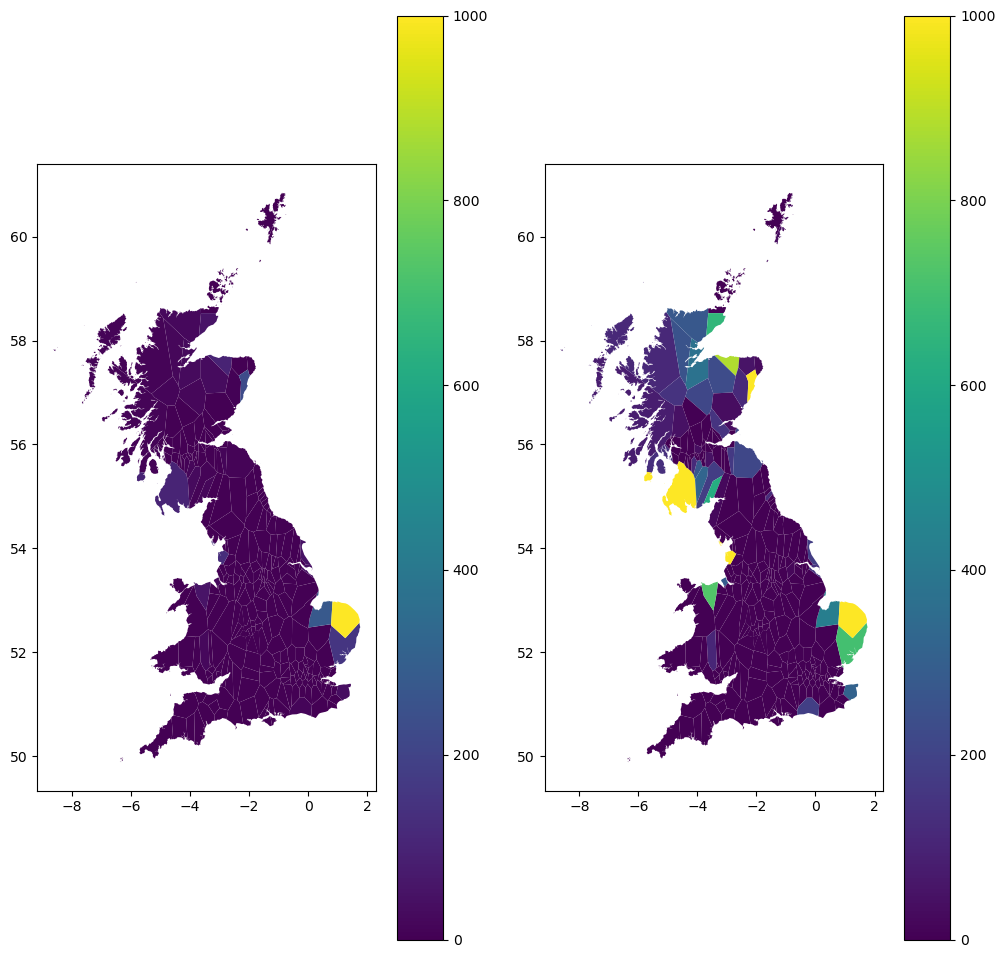

In [116]:

def bus_generation_to_ax(n, ax, nodal_regions):

    gen = n.generators.loc[n.generators.carrier.str.contains('wind')]

    missing = gen.index.difference(n.generators_t.p_max_pu.columns)

    gen.loc[:, ['avail']] = (
        pd.concat((
            n.generators_t.p_max_pu[gen.index.intersection(n.generators_t.p_max_pu.columns)].mean(),
            pd.Series(1, missing)
        ))
        .loc[gen.index]
        .mul(gen['p_nom'])
    )

    nodal_regions['avail'] = gen.groupby(gen.bus).avail.sum()
    nodal_regions['avail'] = nodal_regions['avail'].fillna(0)

    nodal_regions.plot(ax=ax, column='avail', legend=True, vmax=1000)


fig, axs = plt.subplots(1, 2, figsize=(12, 12))

n1 = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-20' / 'network_static_s_nodal.nc'
)

bus_generation_to_ax(n1, axs[0], nodal_regions)

n2 = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_static_s_nodal.nc'
)

bus_generation_to_ax(n2, axs[1], nodal_regions)

plt.show()

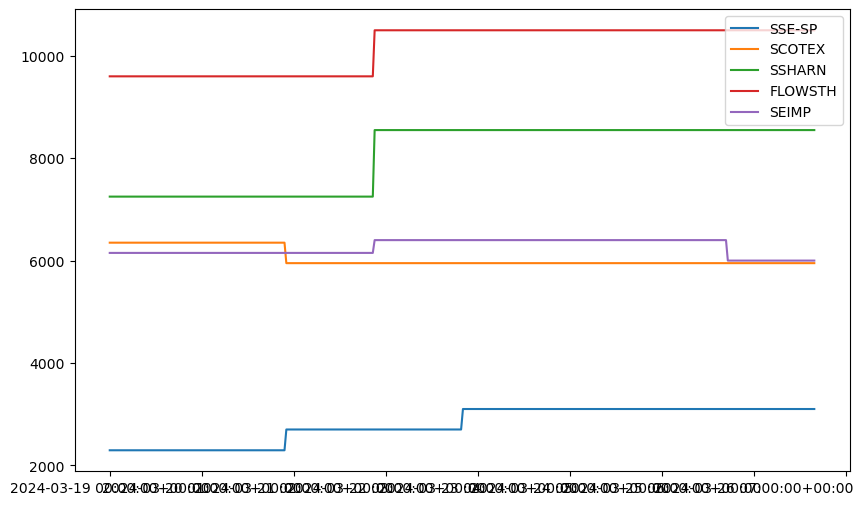

In [337]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
pd.concat(flow_constraints.values()).plot(ax=ax)

plt.show()

<Axes: >

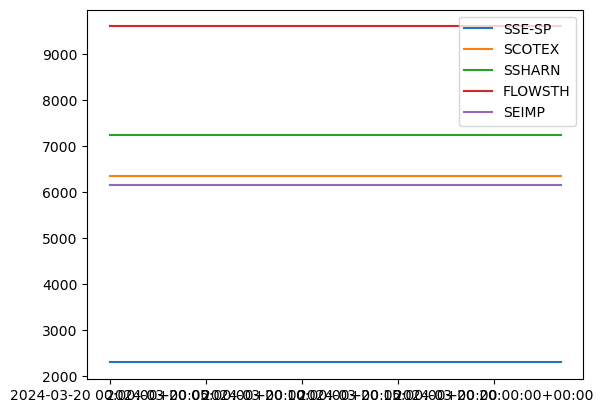

In [334]:
flow_constraints['2024-03-20'].plot()

<Axes: >

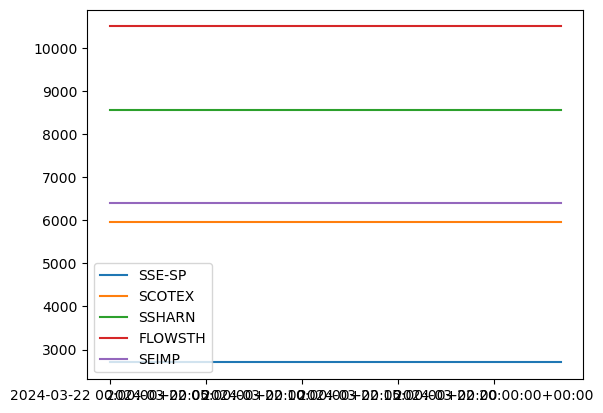

In [335]:
flow_constraints['2024-03-22'].plot()